# Sprint1 機械学習フロー  
＜Sprintの目的＞  
- 機械学習の実践的な流れを知る
- 高い汎化性能を持つモデルを完成させる

＜どのように学ぶか＞  
丁寧な検証が行える状態にした上で、他者の解法を参考に汎化性能の高いモデル作りを進めます。  

Kaggleの **Home Credit Default Risk** コンペティションを題材に、機械学習の実践的な流れを学びます。特に適切な **検証** を行い、高い **汎化性能** のあるモデルを完成させることを目指します。

### 【問題1】クロスバリデーション  
事前学習期間では検証データをはじめに分割しておき、それに対して指標値を計算することで検証を行っていました。**（ホールドアウト法）**しかし、分割の仕方により精度は変化します。実践的には **クロスバリデーション（交差検証）** を行います。分割を複数回行い、それぞれに対して学習と検証を行う方法です。複数回の分割のためにscikit-learnにはKFoldクラスが用意されています。
事前学習期間の課題で作成したベースラインモデルに対してKFoldクラスによるクロスバリデーションを行うコードを作成し実行してください。

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import time
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image

In [2]:
# 訓練データの概観
train = pd.read_csv('application_train.csv')
display(train.head())
display(train.info())

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


None

< numerical variables >


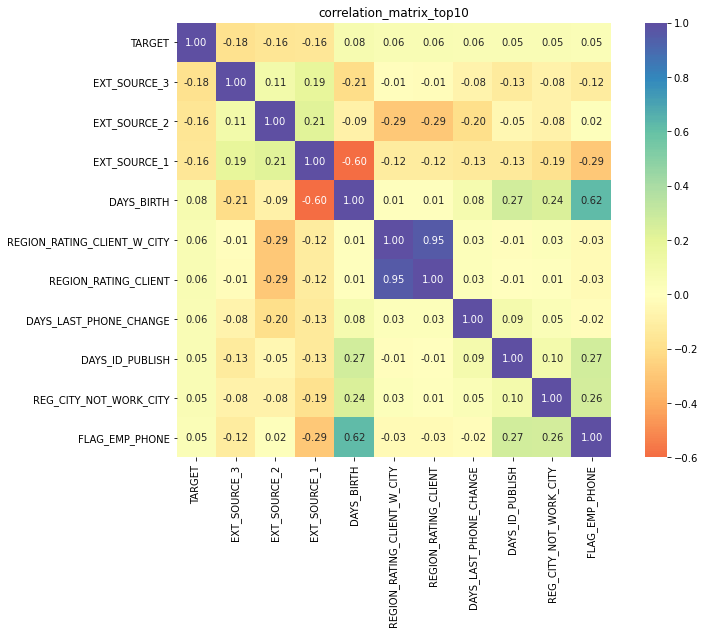

In [3]:
# 相関係数が計算可能な上位10個を取り出す
train_corr = train.corr()
corr_top10 = train_corr['TARGET'].abs().sort_values(ascending=False).index[:11]
plt.figure(figsize=(12,8))
sns.heatmap(train[corr_top10].corr(), cbar=True, annot=True,
            square=True, cmap='Spectral', center=0, fmt='.2f');
print('< numerical variables >')
plt.title("correlation_matrix_top10")
plt.show()

In [4]:
# ひとまず、相関係数上位のEXT_SOURCE_1～3を学習に用いる
df_train = train.loc[:,['TARGET', 'SK_ID_CURR', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']]
display(df_train.head())
display(df_train.describe())
print('< deficits >')
display(df_train.isnull().sum())

,TARGET,SK_ID_CURR,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,1,100002,0.083037,0.262949,0.139376
1,0,100003,0.311267,0.622246,NaN
2,0,100004,NaN,0.555912,0.729567
3,0,100006,NaN,0.650442,NaN
4,0,100007,NaN,0.322738,NaN


,TARGET,SK_ID_CURR,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
count,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000
mean,0.080729,278180.518577,0.502130,5.143927e-01,0.510853
std,0.272419,102790.175348,0.211062,1.910602e-01,0.194844
min,0.000000,100002.000000,0.014568,8.173617e-08,0.000527
25%,0.000000,189145.500000,0.334007,3.924574e-01,0.370650
50%,0.000000,278202.000000,0.505998,5.659614e-01,0.535276
75%,0.000000,367142.500000,0.675053,6.636171e-01,0.669057
max,1.000000,456255.000000,0.962693,8.549997e-01,0.896010


< deficits >


TARGET               0
SK_ID_CURR           0
EXT_SOURCE_1    173378
EXT_SOURCE_2       660
EXT_SOURCE_3     60965
dtype: int64

In [5]:
# 標準化の際に問題となるため、欠損値のあるサンプルを削除
df_train = df_train.dropna()
print('< deficits >')
display(df_train.isnull().sum())

< deficits >


TARGET          0
SK_ID_CURR      0
EXT_SOURCE_1    0
EXT_SOURCE_2    0
EXT_SOURCE_3    0
dtype: int64

In [6]:
# X,yに分割しIDを除く
X = df_train.iloc[:, 1:].values
y = df_train['TARGET'].values
ID = X[:, 0]
print('ID :{}'.format(ID[:3]))
X = X[:, 1:]

ID :[100002. 100009. 100011.]


In [7]:
# KFold(分割：5)
kfold = StratifiedKFold(n_splits=5).split(X, y)
kfold

<generator object _BaseKFold.split at 0x000001EA33377848>

In [8]:
# 学習・推論・評価
# ベースラインモデルとしてLogistic Regression

AUCs = []
for k, (train, test) in enumerate(kfold):
    X_train = X[train]
    X_test = X[test]
    y_train = y[train]
    y_test = y[test]
    sc = StandardScaler()
    sc.fit(X_train)
    X_train_std = sc.transform(X_train)
    X_test_std = sc.transform(X_test)
    lr = LogisticRegression()
    lr.fit(X_train_std, y_train)
    probs = lr.predict_proba(X_test_std)
    AUC = roc_auc_score(y_test, probs[:, 1])
    AUCs.append(AUC)
    print('Fold:{}, class dist.:{}, AUC:{:.3f}'
          .format(k+1, np.bincount(y_train), AUC))
    
print('Cross Validation AUC : {:.3f} +/- {:.3f}'.format(np.mean(AUCs), np.std(AUCs)))

Fold:1, class dist.:[81273  6398], AUC:0.743
Fold:2, class dist.:[81273  6398], AUC:0.745
Fold:3, class dist.:[81273  6398], AUC:0.736
Fold:4, class dist.:[81272  6399], AUC:0.746
Fold:5, class dist.:[81273  6399], AUC:0.741
Cross Validation AUC : 0.742 +/- 0.004


### 【問題2】グリッドサーチ  
これまで分類器のパラメータには触れず、デフォルトの設定を使用していました。パラメータの詳細は今後のSprintで学んでいくことになります。機械学習の前提として、パラメータは状況に応じて最適なものを選ぶ必要があります。最適なパラメータを探していくことを パラメータチューニング と呼びます。**パラメータチューニング**をある程度自動化する単純な方法としては **グリッドサーチ** があります。
scikit-learnのGridSearchCVを使い、グリッドサーチを行うコードを作成してください。そして、ベースラインモデルに対して何らかしらのパラメータチューニングを行なってください。どのパラメータをチューニングするかは、使用した手法の公式ドキュメントを参考にしてください。
GridSearchCVクラスには引数としてモデル、探索範囲、さらにクロスバリデーションを何分割で行うかを与えます。クロスバリデーションの機能も含まれているため、これを使用する場合はKFoldクラスを利用する必要はありません。

In [9]:
# 前処理として標準化
sc = StandardScaler()
sc.fit(X)
X_std = sc.transform(X)

In [10]:
# grid searchで学習
svc = SVC(max_iter=100, probability=True)
parameters = {'kernel':('linear', 'rbf'), 'C':[0.1, 1, 10]}
gs = GridSearchCV(estimator=svc, 
                  param_grid=parameters,
                  n_jobs=-1,
                  cv=5)
gs = gs.fit(X_std, y)

In [11]:
# 結果の確認
print('best score : {:.3f}'.format(gs.best_score_))
print('best parameters : {}'.format(gs.best_params_))
probs = gs.predict_proba(X_std)
print('Grid Search AUC : {:.3f}'.format(roc_auc_score(y, probs[:, 1])))

best score : 0.799
best parameters : {'C': 0.1, 'kernel': 'rbf'}
Grid Search AUC : 0.612


In [12]:
# grid searchで学習
svc = SVC(max_iter=100, probability=True)
parameters = {'kernel':('linear', 'rbf'), 'C':[0.1, 1, 10]}
gs_1 = GridSearchCV(estimator=svc, 
                    param_grid=parameters, 
                    scoring='roc_auc',
                    n_jobs=-1,
                    cv=5)
gs_1 = gs_1.fit(X_std, y)

In [13]:
# 結果の確認
print('best score : {:.3f}'.format(gs_1.best_score_))
print('best parameters : {}'.format(gs_1.best_params_))
probs_1 = gs_1.predict_proba(X_std)
print('Grid Search AUC : {:.3f}'.format(roc_auc_score(y, probs_1[:, 1])))

best score : 0.714
best parameters : {'C': 0.1, 'kernel': 'linear'}
Grid Search AUC : 0.350


- scoring : roc_aucに設定するとランダム選択よりもAUCの値が小さい...

### 【問題3】Kaggle Notebooksからの調査  
KaggleのNotebooksから様々なアイデアを見つけ出して、列挙してください。


以下の観点に注目

1. 外れ値の処理
2. 多次元の特徴量作成
3. 仮説からの特徴量作成
4. 学習モデルとしてlightGBMの使用
5. チューニングとしてRandom SearchとBayesian Optimization

### 1. 外れ値の処理
'DAYS_EMPLOYED'：勤続期間（日）のデータに外れ値が含まれているため、補正する

In [17]:
# 勤続期間を確認
train = pd.read_csv('application_train.csv')
display(train.loc[:, 'DAYS_EMPLOYED'].describe())

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

- 最大値が365243日＝約1000年はおかしい

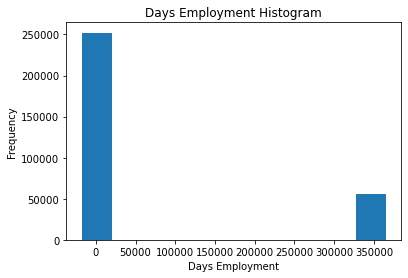

In [18]:
# ヒストグラム確認
train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

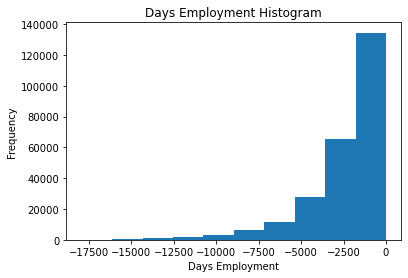

In [19]:
# 外れ値の補正
train['DAYS_EMPLOYED_ANOM'] = train["DAYS_EMPLOYED"] == 365243

# 外れ値をNaNで置き換える
train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

- 外れ値は取り除かれ、勤続年数として自然な分布となった

### 2. 多次元の特徴量作成
線形の関係ではない多次元の関係性（${x_1}^2$）や、2つの特徴量の相互作用（${x_1}\cdot{x_2}$）の影響を探る

In [20]:
# 多項式の特徴量作成
poly_features = train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_target = poly_features['TARGET']
poly_features = poly_features.drop(columns = ['TARGET'])
poly_features = poly_features.fillna(poly_features.median())

poly_transformer = PolynomialFeatures(degree = 3)
poly_transformer.fit(poly_features)
poly_features = poly_transformer.transform(poly_features)
print('Polynomial Features shape: ', poly_features.shape)
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

Polynomial Features shape:  (307511, 35)


['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

In [21]:
# これらの特徴量と、TARGETとの相関係数を確認
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))
poly_features['TARGET'] = poly_target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
EXT_SOURCE_3                             -0.155892
EXT_SOURCE_1 EXT_SOURCE_3^2              -0.150822
Name: TARGET, dtype: float64
EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH    0.155891
EXT_SOURCE_2 DAYS_BIRTH                 0.156873
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH    0.181283
TARGET                                  1.000000
1                                            NaN
Name: TARGET, dtype: float64


- 既存の数値変数で相関の高い'EXT_SOURCE'の1～3と'DAYS_BIRTH'を、最高次元：3までで掛け合わせて特徴量を作成してみた。
- 少なくとも相関係数上は、特にTARGETとの相関が元の変数単独と比較して大きくなるような特徴量は見つからなかった。

### 3. 仮説から特徴量を作成  

返済の遅延に関係しそうな特徴量の例として、以下のものがあった。

- ``CREDIT_INCOME_PERCENT`` : 収入あたりの負債額  
（仮説：収入が多くても負債が大きければ破綻しやすい）


- ``ANNUITY_INCOME_PERCENT`` : 収入に対する月々の支払額  
（仮説：収入が多くても月々の支払いが高額であれば破綻しやすい）


- ``CREDIT_TERM`` : 支払期間  
（仮説：支払期間が長ければ金利が多くなる分破綻しやすい）


- ``DAYS_EMPLOYED_PERCENT`` : 年齢に対する就業期間の割合  
（仮説：年齢が高くても就業期間が短ければ、収入が不安定で破綻しやすい）

In [22]:
# 仮説より特徴量と作成
train_domain = train.copy()

train_domain['CREDIT_INCOME_PERCENT'] = train_domain['AMT_CREDIT'] / train_domain['AMT_INCOME_TOTAL']
train_domain['ANNUITY_INCOME_PERCENT'] = train_domain['AMT_ANNUITY'] / train_domain['AMT_INCOME_TOTAL']
train_domain['CREDIT_TERM'] = train_domain['AMT_ANNUITY'] / train_domain['AMT_CREDIT']
train_domain['DAYS_EMPLOYED_PERCENT'] = train_domain['DAYS_EMPLOYED'] / train_domain['DAYS_BIRTH']

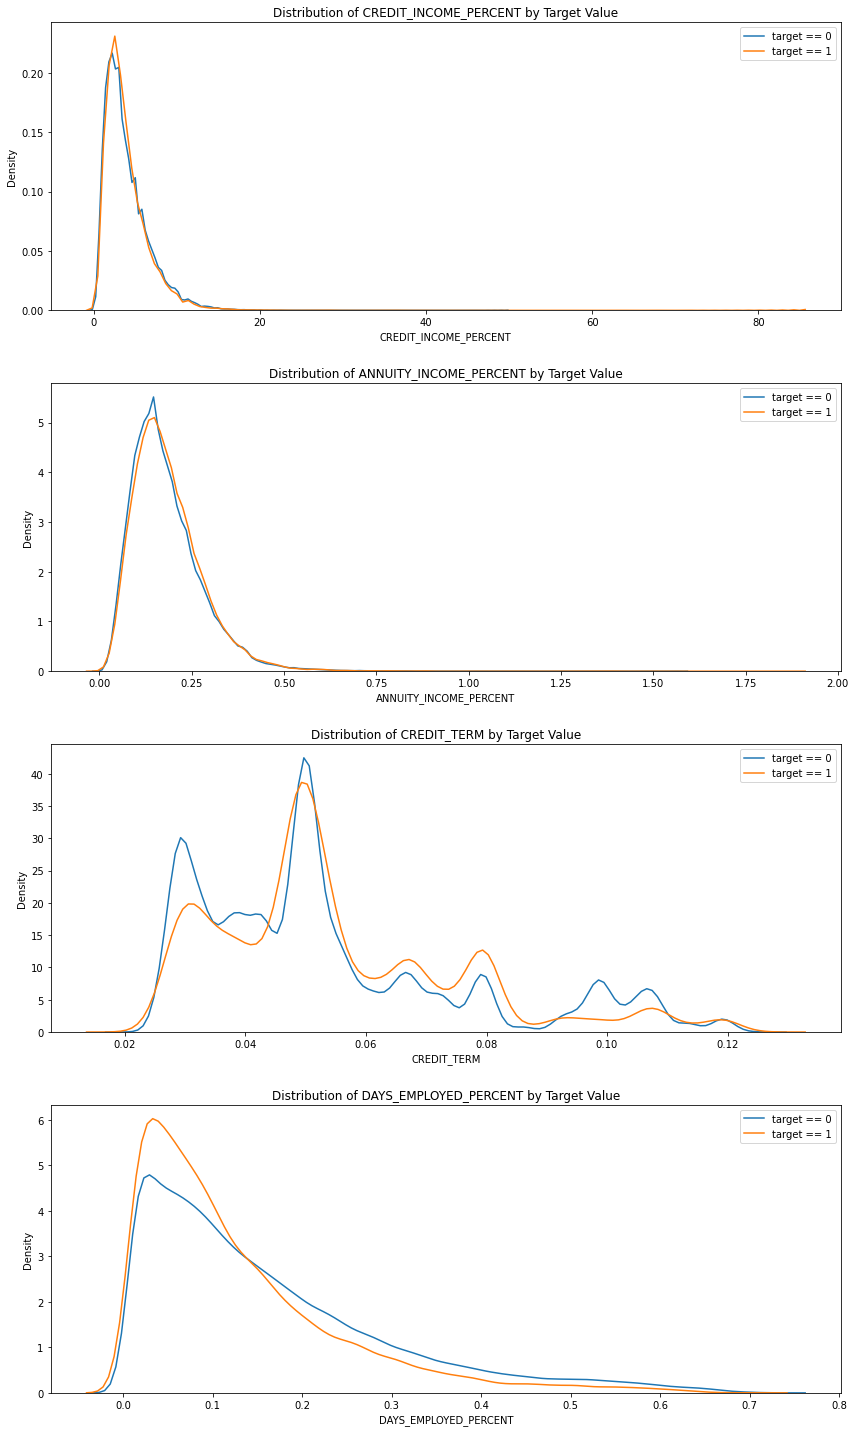

In [23]:
# TARGET毎に、各特徴量の分布を描画
plt.figure(figsize = (12, 20))
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    plt.subplot(4, 1, i + 1)
    sns.kdeplot(train_domain.loc[train_domain['TARGET'] == 0, feature], label = 'target == 0')
    sns.kdeplot(train_domain.loc[train_domain['TARGET'] == 1, feature], label = 'target == 1')
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

- 特に支払期間と年齢に対する就業期間の特徴量で、TARGETの差別化に役立ちそうだ

### 4. 学習モデルとしてLightGBMの使用
LightGBMは勾配ブ―スティング木（Gradiet Boosting Decision Tree；GBDT）の一種で、高速かつ精度が高いため昨今の分析コンペでよく使われているらしい。GBDTも決定木を複数作成していくが、ランダムフォレストが決定木を並列に作成するのに対し、GBDTは直列に作成することで、それまで作成した決定木の予測値を新しい決定木の予測に加えている。  
特にLightGBMは決定木の分岐をヒストグラムベースにすることで高速化を図り、深さ単位でなく葉単位で分岐を追加していくことで精度を上げているらしい。決定木ベースなので数値変数のスケーリングが不要であり、カテゴリ変数もラベルエンコードで反映される。

In [24]:
# ここまで処理したものを使う
df_train = train.copy()

# カテゴリ変数：欠損値補填後、label encoding
# 数値変数：欠損値は中央値で補填
le = LabelEncoder()
n_category = 0
for col in df_train:
    if df_train[col].dtype == 'object':
        df_train[col] = df_train[col].fillna('nan')
        le.fit(df_train[col])
        df_train[col] = le.transform(df_train[col])
        n_category += 1
    else:
        df_train[col] = df_train[col].fillna(df_train[col].median())
            
print('%d columns were label encoded.' % n_category)

16 columns were label encoded.


In [25]:
# データの取り出し
X = df_train.iloc[:, 2:]
y = df_train[['TARGET']]
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, random_state=1, train_size=0.75, stratify=y)

print(np.shape(X_train))
print(np.shape(y_train))
print(np.shape(X_valid))
print(np.shape(y_valid))

(230633, 121)
(230633, 1)
(76878, 121)
(76878, 1)


In [26]:
# LightGBM ハイパーパラメーター初期値の確認
import lightgbm as lgb
lgb.LGBMClassifier()

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [64]:
# LightGBMにて学習
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid)
params = {'task': 'train', 
          'boosting_type': 'gbdt', 
          'objective': 'binary', 
          'metric': 'auc'}

model = lgb.train(params, lgb_train, num_boost_round=100,
                  early_stopping_rounds=10,
                  valid_sets=[lgb_train, lgb_eval],
                  verbose_eval=5)

Training until validation scores don't improve for 10 rounds
[5]	training's auc: 0.728389	valid_1's auc: 0.723602
[10]	training's auc: 0.737936	valid_1's auc: 0.732083
[15]	training's auc: 0.745095	valid_1's auc: 0.738595
[20]	training's auc: 0.751397	valid_1's auc: 0.744047
[25]	training's auc: 0.757232	valid_1's auc: 0.748017
[30]	training's auc: 0.761821	valid_1's auc: 0.751305
[35]	training's auc: 0.765548	valid_1's auc: 0.753464
[40]	training's auc: 0.769202	valid_1's auc: 0.754526
[45]	training's auc: 0.772468	valid_1's auc: 0.755911
[50]	training's auc: 0.775205	valid_1's auc: 0.756669
[55]	training's auc: 0.778021	valid_1's auc: 0.757571
[60]	training's auc: 0.780642	valid_1's auc: 0.758082
[65]	training's auc: 0.782995	valid_1's auc: 0.758424
[70]	training's auc: 0.78538	valid_1's auc: 0.758812
[75]	training's auc: 0.788277	valid_1's auc: 0.758792
[80]	training's auc: 0.790809	valid_1's auc: 0.758982
[85]	training's auc: 0.793469	valid_1's auc: 0.759121
[90]	training's auc: 0.

In [65]:
# 推論・評価
valid_pred = model.predict(X_valid)
AUC = roc_auc_score(y_valid, valid_pred)
print('< LightGBM(1) >')
print('AUC(validation) : {:.3f}'.format(AUC))

< LightGBM(1) >
AUC(validation) : 0.759


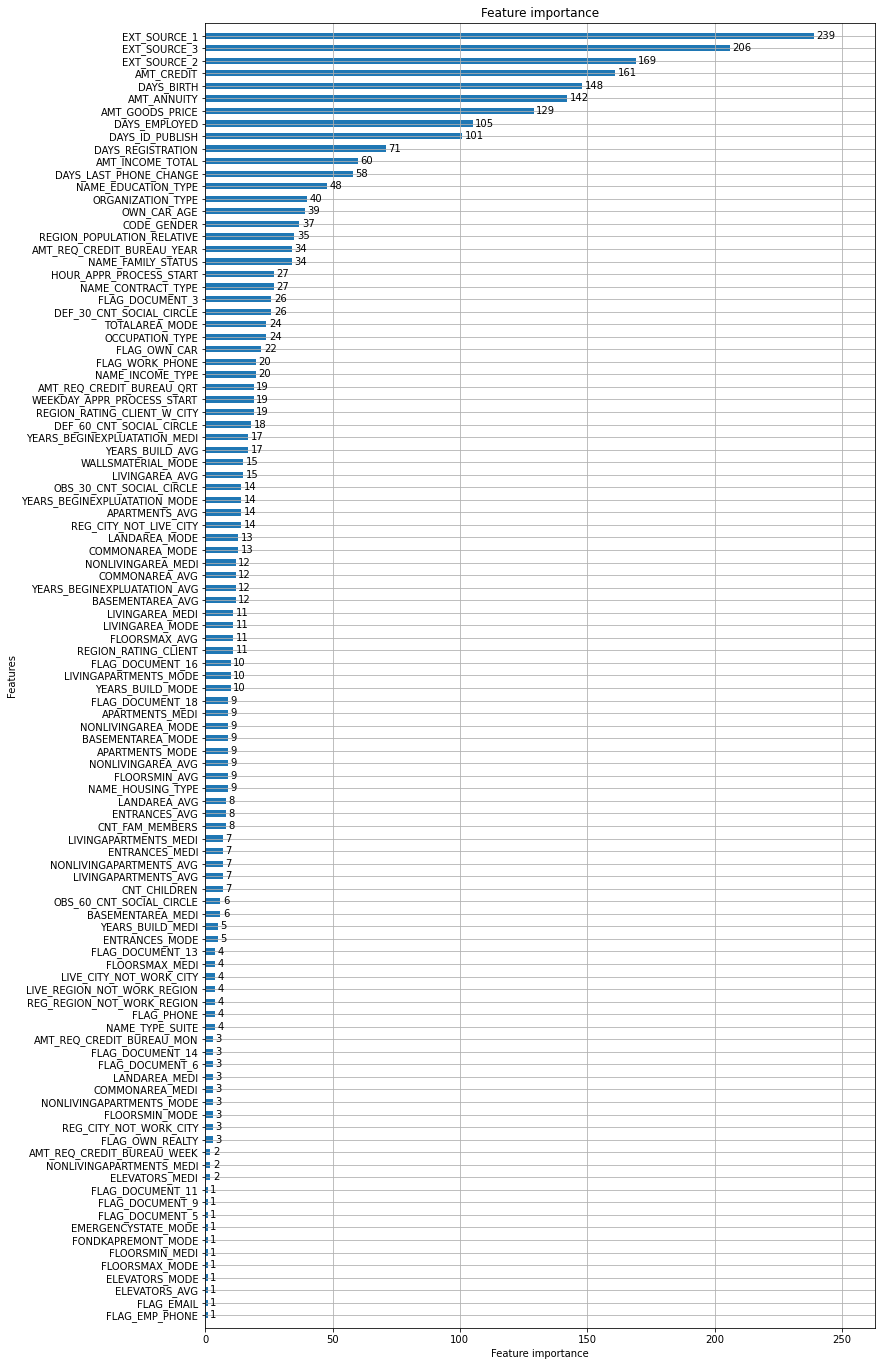

In [66]:
# 特徴量の重要度確認
lgb.plot_importance(model, height=0.5, figsize=(12,24))
plt.show()

- EXT_SOURCEの1～3のみを用いたロジスティック回帰よりも、validationのscoreは高い
- ひとまず上記をbaselineとして、特徴量の追加やハイパーパラメータのチューニングを行ってみる

In [27]:
# 重要度が上位のものを取り出す
df_train_2 = df_train[['TARGET',
                       'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_CREDIT', 
                       'DAYS_BIRTH', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 
                       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'AMT_INCOME_TOTAL', 
                       'ORGANIZATION_TYPE', 'DAYS_LAST_PHONE_CHANGE', 'NAME_EDUCATION_TYPE']]

# これに仮説から作成した4つの特徴量を加える
df_train_domain = train_domain[['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT',
                                'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']]
df_train_2 = pd.concat([df_train_2, df_train_domain], axis=1)
df_train_2.head()

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AMT_CREDIT,DAYS_BIRTH,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,AMT_INCOME_TOTAL,ORGANIZATION_TYPE,DAYS_LAST_PHONE_CHANGE,NAME_EDUCATION_TYPE,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
0,1,0.083037,0.262949,0.139376,406597.5,-9461,24700.5,351000.0,-637.0,-3648.0,-2120,202500.0,5,-1134.0,4,2.007889,0.121978,0.060749,0.067329
1,0,0.311267,0.622246,0.535276,1293502.5,-16765,35698.5,1129500.0,-1188.0,-1186.0,-291,270000.0,39,-828.0,1,4.790750,0.132217,0.027598,0.070862
2,0,0.505998,0.555912,0.729567,135000.0,-19046,6750.0,135000.0,-225.0,-4260.0,-2531,67500.0,11,-815.0,4,2.000000,0.100000,0.050000,0.011814
3,0,0.505998,0.650442,0.535276,312682.5,-19005,29686.5,297000.0,-3039.0,-9833.0,-2437,135000.0,5,-617.0,4,2.316167,0.219900,0.094941,0.159905
4,0,0.505998,0.322738,0.535276,513000.0,-19932,21865.5,513000.0,-3038.0,-4311.0,-3458,121500.0,37,-1106.0,4,4.222222,0.179963,0.042623,0.152418


In [28]:
# 分割
X = df_train_2.iloc[:, 1:]
y = df_train_2.iloc[:, 0]

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, random_state=1, train_size=0.75, stratify=y)

print(np.shape(X_train))
print(np.shape(y_train))
print(np.shape(X_valid))
print(np.shape(y_valid))

(230633, 18)
(230633,)
(76878, 18)
(76878,)


In [69]:
# LightGBMにて学習
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid)
params = {'task': 'train', 
          'boosting_type': 'gbdt', 
          'objective': 'binary', 
          'metric': 'auc'}

model_2 = lgb.train(params, lgb_train, num_boost_round=200,
                  early_stopping_rounds=50,
                  valid_sets=[lgb_train, lgb_eval],
                  verbose_eval=10)

Training until validation scores don't improve for 50 rounds
[10]	training's auc: 0.737095	valid_1's auc: 0.732319
[20]	training's auc: 0.752215	valid_1's auc: 0.745872
[30]	training's auc: 0.761471	valid_1's auc: 0.752952
[40]	training's auc: 0.768657	valid_1's auc: 0.757721
[50]	training's auc: 0.774413	valid_1's auc: 0.759904
[60]	training's auc: 0.779376	valid_1's auc: 0.761071
[70]	training's auc: 0.783589	valid_1's auc: 0.761967
[80]	training's auc: 0.787409	valid_1's auc: 0.762184
[90]	training's auc: 0.791772	valid_1's auc: 0.762214
[100]	training's auc: 0.795423	valid_1's auc: 0.762104
[110]	training's auc: 0.799533	valid_1's auc: 0.761976
[120]	training's auc: 0.803486	valid_1's auc: 0.761958
[130]	training's auc: 0.807043	valid_1's auc: 0.761947
Early stopping, best iteration is:
[83]	training's auc: 0.788957	valid_1's auc: 0.762519


In [71]:
# 推論・評価
valid_pred = model_2.predict(X_valid)
AUC = roc_auc_score(y_valid, valid_pred)
print('< LightGBM(2) >')
print('AUC(validation) : {:.3f}'.format(AUC))

< LightGBM(2) >
AUC(validation) : 0.763


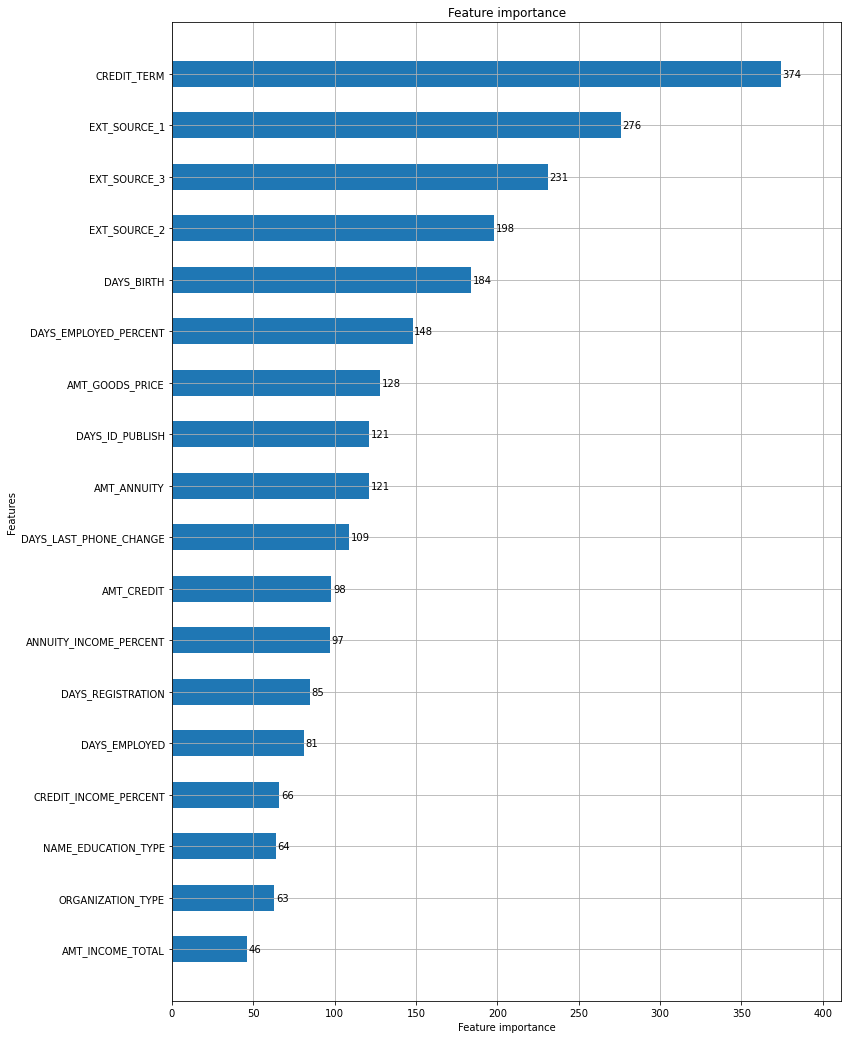

In [72]:
# 特徴量の重要度確認
lgb.plot_importance(model_2, height=0.5, figsize=(12,18))
plt.show()

- 仮説の特徴量追加により、スコアは上がった
- 以後はこの特徴量を用いて、チューニングを行う

### 5. Random Search / Bayesian optimization  
Grid Searchは、すべての組み合わせをしらみつぶしに試すため、時間がかかる。  
Random Searchは、各パラメータごとにランダムに選んだ組み合わせを作り、設定した回数まで繰り返す方法。探索の対象が多い場合でも探索が可能だが、全ての組み合わせを試すわけではないので、最善の結果は得られないかもしれない。  
Bayesian optimizationは、以前に計算したパラメータの履歴に基づいて、次に検索するべきパラメータをベイズ確率の枠組みを用いて選択する方法。精度が良い可能性の高いパラメータを効率良く探索することが可能とのこと。  

上記の3つで、一通りLightGBMのチューニングを試みる。

In [ ]:
# grid searchの時間を計測
lgb_grid = lgb.LGBMClassifier(silent=False)
param_grid = {"max_depth": [5, 6, 7, 8, 9],
              "min_child_weight" : [0.0001, 0.001, 0.01],
              "learning_rate" : [0.01,0.05,0.1],
              "num_leaves": [10,30,90],
              "n_estimators": [100,200,300]}

model_grid = GridSearchCV(estimator = lgb_grid,
                          param_grid = param_grid,
                          scoring = 'roc_auc',
                          cv = 5,
                          verbose=3,
                          return_train_score = True,
                          n_jobs = -1)

t1 = time.time()
model_grid.fit(X, y)
t2 = time.time()

- 90分程待ったが、学習が終わらないため中断...

In [73]:
# Random searchの時間を計算
lgb_random = lgb.LGBMClassifier(silent=False)
param_dist = {"max_depth": [5, 6, 7, 8, 9],
              "min_child_weight" : [0.0001, 0.001, 0.01],
              "learning_rate" : [0.01,0.05,0.1],
              "num_leaves": [10,30,90],
              "n_estimators": [100,200,300]}

model_random = RandomizedSearchCV(estimator = lgb_random,
                                  param_distributions = param_dist,
                                  scoring = 'roc_auc',
                                  cv = 5,
                                  n_iter=10,
                                  verbose=3,
                                  return_train_score = True,
                                  n_jobs = -1) 

t3 = time.time()
model_random.fit(X, y)
t4 = time.time()

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.8min finished


In [100]:
# スコア
print(model_random.best_estimator_)
print('best parameters : \n{}'.format(model_random.best_params_))
print('best score : \n{}'.format(model_random.best_score_))
print('run time : {}'.format(int(t4-t3)))

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.05, max_depth=5,
               min_child_samples=20, min_child_weight=0.01, min_split_gain=0.0,
               n_estimators=300, n_jobs=-1, num_leaves=90, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
best parameters : 
{'num_leaves': 90, 'n_estimators': 300, 'min_child_weight': 0.01, 'max_depth': 5, 'learning_rate': 0.05}
best score : 
0.7606585906309029
run time : 230


In [101]:
# 推論・評価
valid_pred = model_random.predict(X_valid)
AUC = roc_auc_score(y_valid, valid_pred)
print('< LightGBM(Random) >')
print('AUC(valid) : {:.3f}'.format(AUC))

< LightGBM(Random) >
AUC(valid) : 0.512


- チューニングによって、むしろAUCは低下
- n_iterが少なすぎた...

In [78]:
# Bayesian optimizationの時間を計測
import optuna.integration.lightgbm as lgb
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid)
params = {'task': 'train', 
          'boosting_type': 'gbdt', 
          'objective': 'binary', 
          'metric': 'auc'}

best_params, tuning_history = dict(), list()

t5 = time.time()
model_bayes = lgb.train(params, lgb_train, valid_sets=lgb_eval,
              best_params=best_params,
              tuning_history=tuning_history,
              verbose_eval=0)
t6 = time.time()

tune_num_leaves, val_score: 0.766321: 100%|############################################| 20/20 [06:30<00:00, 19.52s/it]
tune_bagging_fraction_and_bagging_freq, val_score: 0.766705:  10%|##2                   | 1/10 [00:14<02:09, 14.38s/it][I 2020-05-07 08:56:14,948] Finished trial#0 with value: 0.766704954019608 with parameters: {'bagging_fraction': 0.9899952816125043, 'bagging_freq': 1}. Best is trial#0 with value: 0.766704954019608.
tune_bagging_fraction_and_bagging_freq, val_score: 0.766705:  20%|####4                 | 2/10 [00:26<01:48, 13.62s/it][I 2020-05-07 08:56:26,814] Finished trial#1 with value: 0.7647218989036222 with parameters: {'bagging_fraction': 0.554195499437957, 'bagging_freq': 1}. Best is trial#0 with value: 0.766704954019608.
tune_bagging_fraction_and_bagging_freq, val_score: 0.766902:  30%|######6               | 3/10 [00:38<01:32, 13.21s/it][I 2020-05-07 08:56:39,054] Finished trial#2 with value: 0.7669018324594915 with parameters: {'bagging_fraction': 0.7610780

tune_lambda_l1_and_lambda_l2, val_score: 0.768252:  45%|##############4                 | 9/20 [01:51<02:16, 12.37s/it][I 2020-05-07 09:01:09,972] Finished trial#8 with value: 0.7673110456727884 with parameters: {'lambda_l1': 0.0005255332817329445, 'lambda_l2': 4.315571281730243e-08}. Best is trial#4 with value: 0.7682522107550217.
tune_lambda_l1_and_lambda_l2, val_score: 0.768252:  50%|###############5               | 10/20 [02:03<02:02, 12.29s/it][I 2020-05-07 09:01:22,078] Finished trial#9 with value: 0.7676247096060682 with parameters: {'lambda_l1': 0.6503343817927392, 'lambda_l2': 7.223005617942756e-05}. Best is trial#4 with value: 0.7682522107550217.
tune_lambda_l1_and_lambda_l2, val_score: 0.768252:  55%|#################              | 11/20 [02:15<01:50, 12.25s/it][I 2020-05-07 09:01:34,240] Finished trial#10 with value: 0.7670853499147925 with parameters: {'lambda_l1': 0.06791843299983177, 'lambda_l2': 3.804978495570879}. Best is trial#4 with value: 0.7682522107550217.
tune_l

In [102]:
print('Best Parameters : \n{}'.format(best_params))
print('\nrun time : {}sec'.format(int(t6-t5)))

Best Parameters : 
{'lambda_l1': 9.447669877216741, 'lambda_l2': 9.64295328790841e-08, 'num_leaves': 4, 'feature_fraction': 0.7200000000000001, 'bagging_fraction': 0.9619500033089816, 'bagging_freq': 3, 'min_child_samples': 20}

run time : 989sec


In [103]:
# 推論・評価
valid_pred = model_bayes.predict(X_valid)
AUC = roc_auc_score(y_valid, valid_pred)
print('< LightGBM(Bayesian) >')
print('AUC(valid) : {:.3f}'.format(AUC))

< LightGBM(Bayesian) >
AUC(valid) : 0.768


- tuningなしと比較して、わずかにスコアが向上した

### おまけ
単に、k-foldのみだとどうなるか？

In [137]:
# K-fold
X = df_train_2.iloc[:, 1:].values
y = df_train_2.iloc[:, 0].values
kfold = StratifiedKFold(n_splits=5).split(X, y)

for train_index, test_index in kfold:
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)
    y_train = pd.DataFrame(y_train)
    y_test = pd.DataFrame(y_test)
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid)
    params = {'task': 'train', 
              'boosting_type': 'gbdt', 
              'objective': 'binary', 
              'metric': 'auc'}

    model_cv = lgb.train(params, lgb_train, num_boost_round=200,
                         early_stopping_rounds=50,
                         valid_sets=[lgb_train, lgb_eval],
                         verbose_eval=20)

Training until validation scores don't improve for 50 rounds
[20]	training's auc: 0.752826	valid_1's auc: 0.741846
[40]	training's auc: 0.769423	valid_1's auc: 0.753788
[60]	training's auc: 0.780339	valid_1's auc: 0.757777
[80]	training's auc: 0.788553	valid_1's auc: 0.758611
[100]	training's auc: 0.794954	valid_1's auc: 0.758766
[120]	training's auc: 0.801675	valid_1's auc: 0.75946
[140]	training's auc: 0.808077	valid_1's auc: 0.759578
[160]	training's auc: 0.813905	valid_1's auc: 0.759599
[180]	training's auc: 0.818681	valid_1's auc: 0.759449
[200]	training's auc: 0.823607	valid_1's auc: 0.759285
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.823607	valid_1's auc: 0.759285
Training until validation scores don't improve for 50 rounds
[20]	training's auc: 0.752126	valid_1's auc: 0.741331
[40]	training's auc: 0.769682	valid_1's auc: 0.753182
[60]	training's auc: 0.780624	valid_1's auc: 0.756888
[80]	training's auc: 0.788565	valid_1's auc: 0.757871
[100]	training

In [138]:
# 推論・評価
valid_pred = model_cv.predict(X_valid)
AUC = roc_auc_score(y_valid, valid_pred)
print('< LightGBM(K-fold) >')
print('AUC(valid) : {:.3f}'.format(AUC))

< LightGBM(K-fold) >
AUC(valid) : 0.761


- hold out（0.763）よりも値はわずかに低いが、汎化性能は上がっているだろう

### ＜Tuningのまとめ＞
- 上記の挙動をみるに、実践的にはByesianで絞込んだ後、狭い範囲を手動でGridSreachしていくことになるか

### 【問題4】高い汎化性能のモデル作成  
最終的にこれは良いというモデルを選び、推定した結果をKaggleに提出してスコアを確認してください。どういったアイデアを取り入れ、どの程度のスコアになったかを記載してください。

- 重要度の高い14の特徴量に、仮説から作成した4つの特徴量を加えて学習に用いる
- 問題3でBayesian optimizationでtuningしたモデルで提出する

In [180]:
# テストデータの読み込み
test = pd.read_csv('application_test.csv')

test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

test_domain = test.copy()
test_domain['CREDIT_INCOME_PERCENT'] = test_domain['AMT_CREDIT'] / test_domain['AMT_INCOME_TOTAL']
test_domain['ANNUITY_INCOME_PERCENT'] = test_domain['AMT_ANNUITY'] / test_domain['AMT_INCOME_TOTAL']
test_domain['CREDIT_TERM'] = test_domain['AMT_ANNUITY'] / test_domain['AMT_CREDIT']
test_domain['DAYS_EMPLOYED_PERCENT'] = test_domain['DAYS_EMPLOYED'] / test_domain['DAYS_BIRTH']

df_test = test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_CREDIT', 
                'DAYS_BIRTH', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 
                'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'AMT_INCOME_TOTAL', 
                'ORGANIZATION_TYPE', 'DAYS_LAST_PHONE_CHANGE', 'NAME_EDUCATION_TYPE']]

df_test_domain = test_domain[['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT',
                             'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']]

df_test = pd.concat([df_test, df_test_domain], axis=1)
df_test.head()

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AMT_CREDIT,DAYS_BIRTH,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,AMT_INCOME_TOTAL,ORGANIZATION_TYPE,DAYS_LAST_PHONE_CHANGE,NAME_EDUCATION_TYPE,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
0,0.752614,0.789654,0.159520,568800.0,-19241,20560.5,450000.0,-2329.0,-5170.0,-812,135000.0,Kindergarten,-1740.0,Higher education,4.213333,0.152300,0.036147,0.121044
1,0.564990,0.291656,0.432962,222768.0,-18064,17370.0,180000.0,-4469.0,-9118.0,-1623,99000.0,Self-employed,0.0,Secondary / secondary special,2.250182,0.175455,0.077973,0.247398
2,NaN,0.699787,0.610991,663264.0,-20038,69777.0,630000.0,-4458.0,-2175.0,-3503,202500.0,Transport: type 3,-856.0,Higher education,3.275378,0.344578,0.105202,0.222477
3,0.525734,0.509677,0.612704,1575000.0,-13976,49018.5,1575000.0,-1866.0,-2000.0,-4208,315000.0,Business Entity Type 3,-1805.0,Secondary / secondary special,5.000000,0.155614,0.031123,0.133515
4,0.202145,0.425687,NaN,625500.0,-13040,32067.0,625500.0,-2191.0,-4000.0,-4262,180000.0,Business Entity Type 3,-821.0,Secondary / secondary special,3.475000,0.178150,0.051266,0.168021


In [84]:
# ラベルエンコード
n_category = 0
for col in df_test:
    if df_test[col].dtype == 'object':
        df_test[col] = df_test[col].fillna('nan')
        le.fit(df_test[col])
        df_test[col] = le.transform(df_test[col])
        n_category += 1
    else:
        df_test[col] = df_test[col].fillna(df_test[col].median())
            
print('%d columns were label encoded.' % n_category)
display(df_test.isnull().sum())

2 columns were label encoded.


EXT_SOURCE_1              0
EXT_SOURCE_2              0
EXT_SOURCE_3              0
AMT_CREDIT                0
DAYS_BIRTH                0
AMT_ANNUITY               0
AMT_GOODS_PRICE           0
DAYS_EMPLOYED             0
DAYS_REGISTRATION         0
DAYS_ID_PUBLISH           0
AMT_INCOME_TOTAL          0
ORGANIZATION_TYPE         0
DAYS_LAST_PHONE_CHANGE    0
NAME_EDUCATION_TYPE       0
CREDIT_INCOME_PERCENT     0
ANNUITY_INCOME_PERCENT    0
CREDIT_TERM               0
DAYS_EMPLOYED_PERCENT     0
dtype: int64

In [88]:
# 推定
pred = model_bayes.predict(df_test)

# csvファイル作成
df_submission =pd.DataFrame({'SK_ID_CURR': test['SK_ID_CURR'], 'TARGET': pred})
display(df_submission.head())
df_submission.to_csv('submission3_csv', index=False, header=True)

,SK_ID_CURR,TARGET
0,100001,0.044040
1,100005,0.082766
2,100013,0.012386
3,100028,0.039071
4,100038,0.128357


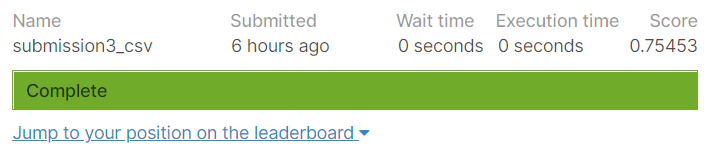

In [170]:
# Kaggleに提出
Image("5-1.png")

### その他の試み

### 1. 多次元特徴量の効果をみる
まずは多次元特徴量を作成する元となった4つ（EXT_SOURCE_1～3, DAYS_BIRTH）でLightGBMを学習する。  
次に上記で作成した多次元特徴量を用いてLightGBMを学習し、元の特徴量のモデルと比較する。

In [29]:
df_train_3 = df_train[['TARGET',
                       'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']] 
df_train_3.isnull().sum()

TARGET          0
EXT_SOURCE_1    0
EXT_SOURCE_2    0
EXT_SOURCE_3    0
DAYS_BIRTH      0
dtype: int64

In [30]:
# 分割
X = df_train_3.iloc[:, 1:]
y = df_train_3.iloc[:, 0]

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, random_state=1, train_size=0.75, stratify=y)

# LightGBMにて学習
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid)
params = {'task': 'train', 
          'boosting_type': 'gbdt', 
          'objective': 'binary', 
          'metric': 'auc'}

model_3 = lgb.train(params, lgb_train, num_boost_round=200,
                  early_stopping_rounds=50,
                  valid_sets=[lgb_train, lgb_eval],
                  verbose_eval=10)

Training until validation scores don't improve for 50 rounds
[10]	training's auc: 0.728953	valid_1's auc: 0.725282
[20]	training's auc: 0.734008	valid_1's auc: 0.728684
[30]	training's auc: 0.737603	valid_1's auc: 0.73041
[40]	training's auc: 0.740824	valid_1's auc: 0.731254
[50]	training's auc: 0.743999	valid_1's auc: 0.731252
[60]	training's auc: 0.746242	valid_1's auc: 0.731172
[70]	training's auc: 0.747731	valid_1's auc: 0.731084
[80]	training's auc: 0.749804	valid_1's auc: 0.73116
[90]	training's auc: 0.75206	valid_1's auc: 0.730826
Early stopping, best iteration is:
[43]	training's auc: 0.741758	valid_1's auc: 0.731423


< LightGBM(3) >
AUC(validation) : 0.731


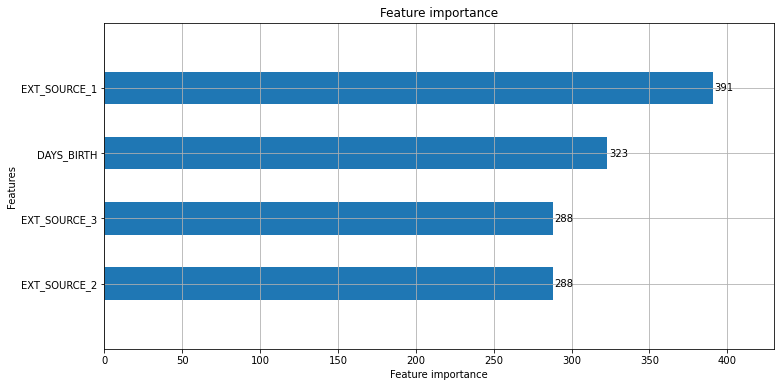

In [31]:
# 推論・評価
valid_pred = model_3.predict(X_valid)
AUC = roc_auc_score(y_valid, valid_pred)
print('< LightGBM(3) >')
print('AUC(validation) : {:.3f}'.format(AUC))

# 特徴量の重要度確認
lgb.plot_importance(model_3, height=0.5, figsize=(12,6))
plt.show()

- DAYS_BIRTHの重要度の順位が上がっている
- 別の観点からの特徴量によってということか

In [32]:
# 高次の特徴量
display(poly_features.head())

# 分割
X = poly_features.iloc[:, 1:-1]
y = poly_features.iloc[:, -1]

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, random_state=1, train_size=0.75, stratify=y)

display(X.head())
display(y.head())

,1,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,EXT_SOURCE_1^2,EXT_SOURCE_1 EXT_SOURCE_2,EXT_SOURCE_1 EXT_SOURCE_3,EXT_SOURCE_1 DAYS_BIRTH,EXT_SOURCE_2^2,...,EXT_SOURCE_2^2 EXT_SOURCE_3,EXT_SOURCE_2^2 DAYS_BIRTH,EXT_SOURCE_2 EXT_SOURCE_3^2,EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH,EXT_SOURCE_2 DAYS_BIRTH^2,EXT_SOURCE_3^3,EXT_SOURCE_3^2 DAYS_BIRTH,EXT_SOURCE_3 DAYS_BIRTH^2,DAYS_BIRTH^3,TARGET
0,1.0,0.083037,0.262949,0.139376,-9461.0,0.006895,0.021834,0.011573,-785.612748,0.069142,...,0.009637,-654.152107,0.005108,-346.733022,2.353667e+07,0.002707,-183.785678,1.247560e+07,-8.468590e+11,1
1,1.0,0.311267,0.622246,0.535276,-16765.0,0.096887,0.193685,0.166614,-5218.396475,0.387190,...,0.207254,-6491.237078,0.178286,-5583.975307,1.748916e+08,0.153368,-4803.518937,1.504475e+08,-4.712058e+12,0
2,1.0,0.505998,0.555912,0.729567,-19046.0,0.256034,0.281290,0.369159,-9637.236584,0.309038,...,0.225464,-5885.942404,0.295894,-7724.580288,2.016572e+08,0.388325,-10137.567875,2.646504e+08,-6.908939e+12,0
3,1.0,0.505998,0.650442,0.535276,-19005.0,0.256034,0.329122,0.270849,-9616.490669,0.423074,...,0.226462,-8040.528832,0.186365,-6616.894625,2.349331e+08,0.153368,-5445.325225,1.933364e+08,-6.864416e+12,0
4,1.0,0.505998,0.322738,0.535276,-19932.0,0.256034,0.163305,0.270849,-10085.550751,0.104160,...,0.055754,-2076.117157,0.092471,-3443.335521,1.282190e+08,0.153368,-5710.929881,2.126570e+08,-7.918677e+12,0


,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,EXT_SOURCE_1^2,EXT_SOURCE_1 EXT_SOURCE_2,EXT_SOURCE_1 EXT_SOURCE_3,EXT_SOURCE_1 DAYS_BIRTH,EXT_SOURCE_2^2,EXT_SOURCE_2 EXT_SOURCE_3,...,EXT_SOURCE_2^3,EXT_SOURCE_2^2 EXT_SOURCE_3,EXT_SOURCE_2^2 DAYS_BIRTH,EXT_SOURCE_2 EXT_SOURCE_3^2,EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH,EXT_SOURCE_2 DAYS_BIRTH^2,EXT_SOURCE_3^3,EXT_SOURCE_3^2 DAYS_BIRTH,EXT_SOURCE_3 DAYS_BIRTH^2,DAYS_BIRTH^3
0,0.083037,0.262949,0.139376,-9461.0,0.006895,0.021834,0.011573,-785.612748,0.069142,0.036649,...,0.018181,0.009637,-654.152107,0.005108,-346.733022,2.353667e+07,0.002707,-183.785678,1.247560e+07,-8.468590e+11
1,0.311267,0.622246,0.535276,-16765.0,0.096887,0.193685,0.166614,-5218.396475,0.387190,0.333073,...,0.240927,0.207254,-6491.237078,0.178286,-5583.975307,1.748916e+08,0.153368,-4803.518937,1.504475e+08,-4.712058e+12
2,0.505998,0.555912,0.729567,-19046.0,0.256034,0.281290,0.369159,-9637.236584,0.309038,0.405575,...,0.171798,0.225464,-5885.942404,0.295894,-7724.580288,2.016572e+08,0.388325,-10137.567875,2.646504e+08,-6.908939e+12
3,0.505998,0.650442,0.535276,-19005.0,0.256034,0.329122,0.270849,-9616.490669,0.423074,0.348166,...,0.275185,0.226462,-8040.528832,0.186365,-6616.894625,2.349331e+08,0.153368,-5445.325225,1.933364e+08,-6.864416e+12
4,0.505998,0.322738,0.535276,-19932.0,0.256034,0.163305,0.270849,-10085.550751,0.104160,0.172754,...,0.033616,0.055754,-2076.117157,0.092471,-3443.335521,1.282190e+08,0.153368,-5710.929881,2.126570e+08,-7.918677e+12


0    1
1    0
2    0
3    0
4    0
Name: TARGET, dtype: int64

In [34]:
# LightGBMにて学習
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid)
params = {'task': 'train', 
          'boosting_type': 'gbdt', 
          'objective': 'binary', 
          'metric': 'auc'}

model_4 = lgb.train(params, lgb_train, num_boost_round=200,
                  early_stopping_rounds=50,
                  valid_sets=[lgb_train, lgb_eval],
                  verbose_eval=10)

Training until validation scores don't improve for 50 rounds
[10]	training's auc: 0.732575	valid_1's auc: 0.728743
[20]	training's auc: 0.737116	valid_1's auc: 0.730226
[30]	training's auc: 0.742	valid_1's auc: 0.730966
[40]	training's auc: 0.746968	valid_1's auc: 0.731516
[50]	training's auc: 0.751519	valid_1's auc: 0.731612
[60]	training's auc: 0.755104	valid_1's auc: 0.73145
[70]	training's auc: 0.758133	valid_1's auc: 0.731486
[80]	training's auc: 0.761907	valid_1's auc: 0.731205
Early stopping, best iteration is:
[37]	training's auc: 0.74568	valid_1's auc: 0.73169


< LightGBM(4) >
AUC(valid) : 0.732


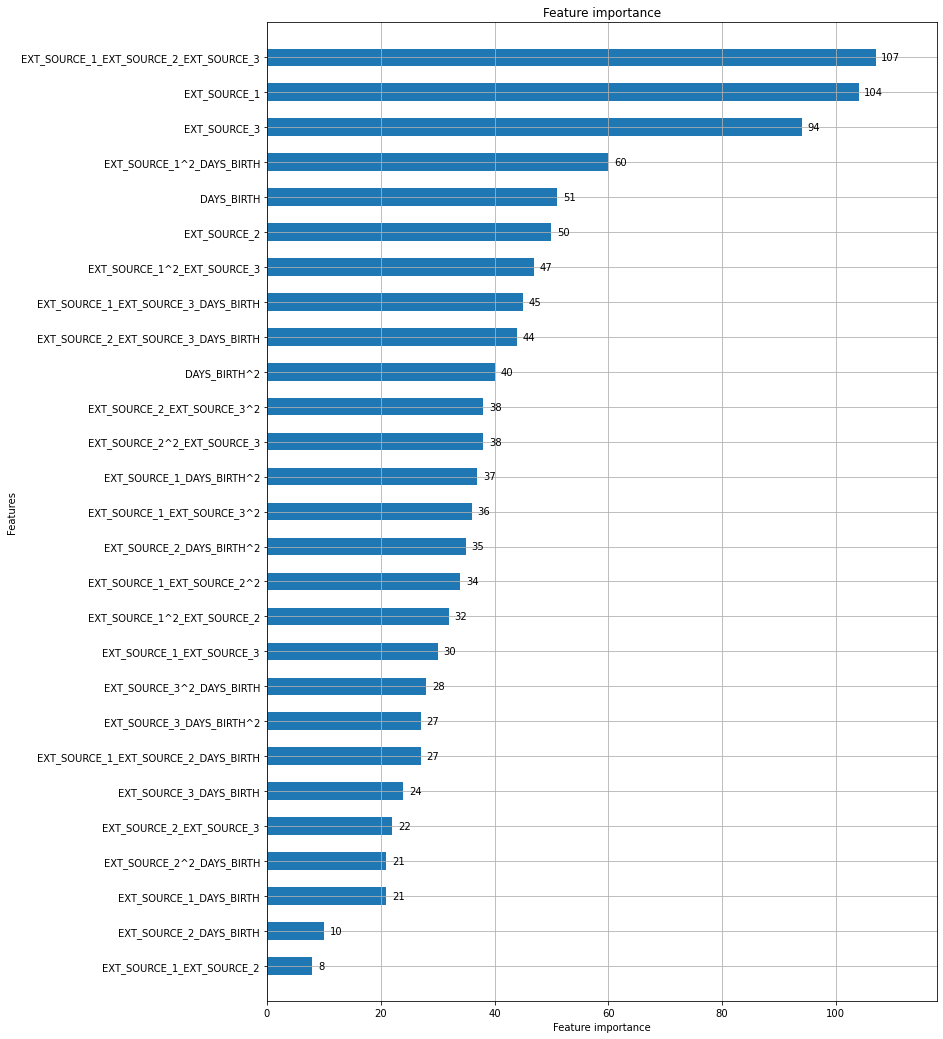

In [35]:
# 推論・評価
valid_pred = model_4.predict(X_valid)
AUC = roc_auc_score(y_valid, valid_pred)
print('< LightGBM(4) >')
print('AUC(valid) : {:.3f}'.format(AUC))

# 特徴量の重要度確認
lgb.plot_importance(model_4, height=0.5, figsize=(12,18))
plt.show()

- 元の特徴量4つ（0.731）と比較しスコアはほとんど変化していない
- これらの特徴量の高次作用や相互作用には特記すべきものは無かったようだが、今回は同じような特徴量を組み合わせている
- 実践的には、組み合わせる特徴量を厳選しないと意味がなさそう

### 2. 職業別のdefault率  
事前学習で作成していた職業別のdefault率をtarget encodingで使用してみる

In [36]:
# 職業ごとのdefault率を算出
df_job = pd.get_dummies(train['OCCUPATION_TYPE'])
display(df_job.head())
df_temp = pd.concat([train['TARGET'], df_job], axis=1)
df_def = df_temp[df_temp['TARGET']==1]
df_def = df_def.drop(['TARGET'], axis=1)

print("\n< total >")
display(df_job.sum())
print("\n< default >")
display(df_def.sum())
print("\n< rate(default/total) >")
display(df_job.sum() / df_def.sum())

,Accountants,Cleaning staff,Cooking staff,Core staff,Drivers,HR staff,High skill tech staff,IT staff,Laborers,Low-skill Laborers,Managers,Medicine staff,Private service staff,Realty agents,Sales staff,Secretaries,Security staff,Waiters/barmen staff
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0



< total >


Accountants               9813
Cleaning staff            4653
Cooking staff             5946
Core staff               27570
Drivers                  18603
HR staff                   563
High skill tech staff    11380
IT staff                   526
Laborers                 55186
Low-skill Laborers        2093
Managers                 21371
Medicine staff            8537
Private service staff     2652
Realty agents              751
Sales staff              32102
Secretaries               1305
Security staff            6721
Waiters/barmen staff      1348
dtype: int64


< default >


Accountants               474
Cleaning staff            447
Cooking staff             621
Core staff               1738
Drivers                  2107
HR staff                   36
High skill tech staff     701
IT staff                   34
Laborers                 5838
Low-skill Laborers        359
Managers                 1328
Medicine staff            572
Private service staff     175
Realty agents              59
Sales staff              3092
Secretaries                92
Security staff            722
Waiters/barmen staff      152
dtype: int64


< rate(default/total) >


Accountants              20.702532
Cleaning staff           10.409396
Cooking staff             9.574879
Core staff               15.863061
Drivers                   8.829141
HR staff                 15.638889
High skill tech staff    16.233951
IT staff                 15.470588
Laborers                  9.452895
Low-skill Laborers        5.830084
Managers                 16.092620
Medicine staff           14.924825
Private service staff    15.154286
Realty agents            12.728814
Sales staff              10.382277
Secretaries              14.184783
Security staff            9.308864
Waiters/barmen staff      8.868421
dtype: float64

In [37]:
# この数値データをそのまま特徴量として用いる
# target encodingというらしい
def_rate_map = {'Accountants':              20.702532,
                'Cleaning staff':           10.409396,
                'Cooking staff':             9.574879,
                'Core staff':               15.863061,
                'Drivers':                   8.829141,
                'HR staff':                 15.638889,
                'High skill tech staff':    16.233951,
                'IT staff':                 15.470588,
                'Laborers':                  9.452895,
                'Low-skill Laborers':        5.830084,
                'Managers':                 16.092620,
                'Medicine staff':           14.924825,
                'Private service staff':    15.154286,
                'Realty agents':            12.728814,
                'Sales staff':              10.382277,
                'Secretaries':              14.184783,
                'Security staff':            9.308864,
                'Waiters/barmen staff':      8.868421}
df_occupation = train['OCCUPATION_TYPE'].map(def_rate_map)
df_occupation

0          9.452895
1         15.863061
2          9.452895
3          9.452895
4         15.863061
            ...    
307506    10.382277
307507          NaN
307508    16.092620
307509     9.452895
307510     9.452895
Name: OCCUPATION_TYPE, Length: 307511, dtype: float64

In [38]:
# 欠損値は中央値で補正
df_occupation = df_occupation.fillna(df_occupation.median())
df_occupation.isnull().sum()

0

In [39]:
# これを加えてみる
df_train_5 = pd.concat([df_train_3, df_occupation], axis=1)
df_train_5.head()

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,OCCUPATION_TYPE
0,1,0.083037,0.262949,0.139376,-9461,9.452895
1,0,0.311267,0.622246,0.535276,-16765,15.863061
2,0,0.505998,0.555912,0.729567,-19046,9.452895
3,0,0.505998,0.650442,0.535276,-19005,9.452895
4,0,0.505998,0.322738,0.535276,-19932,15.863061


In [40]:
# 分割
X = df_train_5.iloc[:, 1:]
y = df_train_5.iloc[:, 0]

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, random_state=1, train_size=0.75, stratify=y)

# LightGBMにて学習
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid)
params = {'task': 'train', 
          'boosting_type': 'gbdt', 
          'objective': 'binary', 
          'metric': 'auc'}

model_5 = lgb.train(params, lgb_train, num_boost_round=200,
                  early_stopping_rounds=50,
                  valid_sets=[lgb_train, lgb_eval],
                  verbose_eval=10)

Training until validation scores don't improve for 50 rounds
[10]	training's auc: 0.731779	valid_1's auc: 0.728314
[20]	training's auc: 0.737121	valid_1's auc: 0.732237
[30]	training's auc: 0.741431	valid_1's auc: 0.734122
[40]	training's auc: 0.744912	valid_1's auc: 0.735214
[50]	training's auc: 0.748266	valid_1's auc: 0.735319
[60]	training's auc: 0.75078	valid_1's auc: 0.735441
[70]	training's auc: 0.753031	valid_1's auc: 0.735327
[80]	training's auc: 0.755133	valid_1's auc: 0.73504
[90]	training's auc: 0.758064	valid_1's auc: 0.734902
[100]	training's auc: 0.760174	valid_1's auc: 0.73479
[110]	training's auc: 0.76235	valid_1's auc: 0.734699
Early stopping, best iteration is:
[64]	training's auc: 0.751724	valid_1's auc: 0.735496


< LightGBM(5) >
AUC(valid) : 0.735


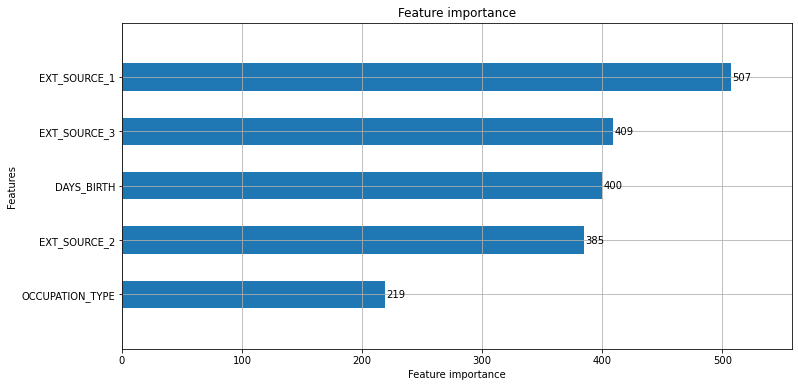

In [41]:
# 推論・評価
valid_pred = model_5.predict(X_valid)
AUC = roc_auc_score(y_valid, valid_pred)
print('< LightGBM(5) >')
print('AUC(valid) : {:.3f}'.format(AUC))

# 特徴量の重要度確認
lgb.plot_importance(model_5, height=0.5, figsize=(12,6))
plt.show()

- 元の特徴量4つ（0.731）と比較し、少しはスコアが良くなっている
- 重要度は最も小さいので、あまり有用な特徴量ではなかったようだ

### ＜結果のまとめ＞

＜Logistic Regression＞
1. EXT_SOURCE_1～3, 5-fold → 0.742

＜LightGBM series＞

1. all features → 0.759

2. select top 14 + domain 4 featurs  
  1) Default → 0.763  
  2) Grid search → stop (over 90min)  
  3) Random search → 0.512  
  4) Byesian optimization → 0.768 (submit : 0.75453)  
  5) 5-fold → 0.761  

3. select 4 (EXT_SOURCE 1～3, DAYS_BIRTH) → 0.731  

4. polynomial (select 4, dimesion : 3) → 0.732  

5. select 4 ＋ occupation default ratio → 0.735  

### ＜考察のまとめ＞  
主に学習モデルtuningの観点から挙動をみてきた。少なくともvalidationのスコアを見る限り、やはり重要なのは特徴量の選択・作成であって、モデルのtuningではそれほどスコアに大きな変化は生じない印象であった。ただ、tuningやcross validationの目的は汎化性能の向上にあると思われるので、今後はハイパーパラメーターの意味などを理解しつつtuningを適切に実施できるようにしていきたい。